In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import shapely.wkt
import shapely.geometry
import pandas as pd
import shapely.geometry.multipolygon as sh

In [2]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
print(thailandmap.unary_union.bounds)
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(97.34335847100004, 5.613037873000053, 105.63696451800007, 20.46507381500004)


<xarray.Dataset>
Dimensions:              (lat: 5346, lon: 2985)
Coordinates:
  * lat                  (lat) float64 5.615 5.618 5.621 ... 20.46 20.46 20.46
  * lon                  (lon) float64 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    lccs_class           (lat, lon) uint8 ...
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) uint16 ...
    change_count         (lat, lon) uint8 ...
    crs                  int32 ...
    lat_bounds           (lat) float64 ...
    lon_bounds           (lon) float64 ...
    time_bounds          datetime64[ns] ...
Attributes: (12/38)
    title:                      Land Cover Map of 2022
    summary:                    This dataset characterizes the land cover of ...
    type:                       C3S-LC-L4-LCCS-Map-300m-P1Y
    references:                 https://cds.climate.copernicus.eu/
    institution:                UCLouvain
    contact:           

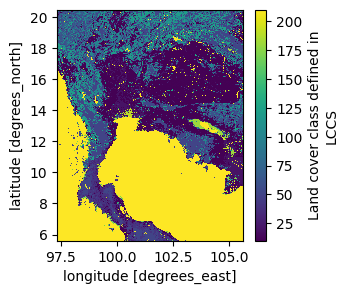

In [3]:
## Then, I acquire data according to the boundary ##
xr_landuse = xr.open_dataset("Data//dataset-satellite-land-cover//C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc")
xr_landuse = xr_landuse.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
xr_landuse = xr_landuse.reindex(lat=xr_landuse.lat[::-1])
xr_landuse = xr_landuse.sel(time = '2022-01-01')
xr_landuse = xr_landuse.drop_vars('time')
xr_landuse = xr_landuse.sel(bounds = 0)
lccs_resolution = 300## meters
print(xr_landuse)
fig, ax = plt.subplots(figsize=(3,3))
xr_landuse['lccs_class'].plot(ax = ax,zorder = 0)

In [4]:
## Here, I assign scores to the land according to the literature ##

## Shrubs and Grassland
xr_landuse['SI_BGEC'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_BGEC'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_BGEC'])
## Natural Reserve
xr_landuse['SI_BGEC'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_BGEC'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_BGEC'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_BGEC'])

## Shrubs and Grassland
xr_landuse['SI_Biomass'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_Biomass'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_Biomass'])
## Natural Reserve
xr_landuse['SI_Biomass'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_Biomass'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_Biomass'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_Biomass'])

## Bare area and Grassland
xr_landuse['SI_Solar'] = xr.where((xr_landuse['lccs_class'].isin([200,201,202,110,130])),3,0) 
## Agriculture
xr_landuse['SI_Solar'] = xr.where((xr_landuse['lccs_class'].isin([10,11,12,20,30,40])),2,xr_landuse['SI_Solar'])
## Short vegetation and shrubs
xr_landuse['SI_Solar'] = xr.where((xr_landuse['lccs_class'].isin([120,121,122,140,150,151,152,153,180])),1,xr_landuse['SI_Solar'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_Solar'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_Solar'])

## Bare area and Grassland
xr_landuse['SI_Wind'] = xr.where((xr_landuse['lccs_class'].isin([200,201,202,110,130])),3,0) 
## Agriculture
xr_landuse['SI_Wind'] = xr.where((xr_landuse['lccs_class'].isin([10,11,12,20,30,40])),2,xr_landuse['SI_Wind'])
## Short vegetation and shrubs
xr_landuse['SI_Wind'] = xr.where((xr_landuse['lccs_class'].isin([120,121,122,140,150,151,152,153,180])),1,xr_landuse['SI_Wind'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_Wind'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_Wind'])

## Shrubs and Grassland
xr_landuse['SI_BGWW'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_BGWW'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_BGWW'])
## Natural Reserve
xr_landuse['SI_BGWW'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_BGWW'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_BGWW'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_BGWW'])

## Shrubs and Grassland
xr_landuse['SI_MSW'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_MSW'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_MSW'])
## Natural Reserve
xr_landuse['SI_MSW'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_MSW'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_MSW'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_MSW'])

## Shrubs and Grassland
xr_landuse['SI_IEW'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_IEW'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_IEW'])
## Natural Reserve
xr_landuse['SI_IEW'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_IEW'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_IEW'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_IEW'])

print(xr_landuse)

<xarray.Dataset>
Dimensions:              (lat: 5346, lon: 2985)
Coordinates:
  * lat                  (lat) float64 5.615 5.618 5.621 ... 20.46 20.46 20.46
  * lon                  (lon) float64 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/16)
    lccs_class           (lat, lon) uint8 210 210 210 210 210 ... 30 40 50 50 50
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) uint16 ...
    change_count         (lat, lon) uint8 ...
    crs                  int32 ...
    ...                   ...
    SI_Biomass           (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    SI_Solar             (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    SI_Wind              (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    SI_BGWW              (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    SI_MSW               (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    S

In [5]:
df_landuse_suitability_index = xr_landuse.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
print('before = ',df_landuse_suitability_index.columns, len(df_landuse_suitability_index))

df_landuse_suitability_index = df_landuse_suitability_index.drop(columns=[
    'processed_flag',
    'current_pixel_state',
    'observation_count',
    'change_count',
    'crs',
    'lat_bounds',
    'lon_bounds',
    'time_bounds',
    ])

df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))
df_landuse_suitability_index.crs = {'init': 'epsg:4326'}

print('after = ',df_landuse_suitability_index.columns, len(df_landuse_suitability_index))


before =  Index(['lat', 'lon', 'lccs_class', 'processed_flag', 'current_pixel_state',
       'observation_count', 'change_count', 'crs', 'lat_bounds', 'lon_bounds',
       'time_bounds', 'SI_BGEC', 'SI_Biomass', 'SI_Solar', 'SI_Wind',
       'SI_BGWW', 'SI_MSW', 'SI_IEW'],
      dtype='object') 15957810
after =  Index(['lat', 'lon', 'lccs_class', 'SI_BGEC', 'SI_Biomass', 'SI_Solar',
       'SI_Wind', 'SI_BGWW', 'SI_MSW', 'SI_IEW', 'geometry'],
      dtype='object') 15957810


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
## Next, I filter out area that are not in Thailand ## 

## Acquire polygon containing boudary of Thailand
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
th = world.loc[world['name'] == 'Thailand'] # get Thailand row
boundaries = th['geometry'] # get Thailand geometry
boundaries.crs = {'init': 'epsg:4326'}
boundaries = boundaries.geometry.unary_union

df_landuse_suitability_index['aux'] = 1
df_landuse_suitability_index['aux'].loc[~df_landuse_suitability_index.within(boundaries)] = 0

df_landuse_suitability_index['SI_BGEC'] = df_landuse_suitability_index['SI_BGEC'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Biomass'] = df_landuse_suitability_index['SI_Biomass'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Solar'] = df_landuse_suitability_index['SI_Solar'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Wind'] = df_landuse_suitability_index['SI_Wind'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_BGWW'] = df_landuse_suitability_index['SI_BGWW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_MSW'] = df_landuse_suitability_index['SI_MSW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_IEW'] = df_landuse_suitability_index['SI_IEW'] * df_landuse_suitability_index['aux']

df_landuse_suitability_index = df_landuse_suitability_index.drop(columns='geometry')
df_landuse_suitability_index = df_landuse_suitability_index.set_index(['lat', 'lon'])
xr_landuse_suitability_index = xr.Dataset.from_dataframe(df_landuse_suitability_index)

print(xr_landuse_suitability_index)

C:\Users\EGAT\AppData\Local\Temp\ipykernel_23732\2665862210.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_filepath = gpd.datasets.get_path('naturalearth_lowres')
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_23732\2665862210.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

<xarray.Dataset>
Dimensions:     (lat: 5346, lon: 2985)
Coordinates:
  * lat         (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon         (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    lccs_class  (lat, lon) uint8 210 210 210 210 210 210 ... 40 30 40 50 50 50
    SI_BGEC     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Biomass  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Solar    (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Wind     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_BGWW     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_MSW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_IEW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    aux         (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0


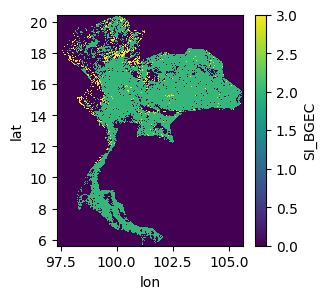

In [7]:
fig, ax = plt.subplots(figsize=(3,3))
xr_landuse_suitability_index['SI_BGEC'].plot(ax = ax,zorder = 0)

In [8]:
## Next, I assign area in proctected area as 0 suitability index ##
pta0 = gpd.read_file('Data\\WDPA_WDOECM_Mar2024_Public_THA_shp_0\\WDPA_WDOECM_Mar2024_Public_THA_shp-polygons.shp')
pta1 = gpd.read_file('Data\\WDPA_WDOECM_Mar2024_Public_THA_shp_1\\WDPA_WDOECM_Mar2024_Public_THA_shp-polygons.shp')
pta2 = gpd.read_file('Data\\WDPA_WDOECM_Mar2024_Public_THA_shp_2\\WDPA_WDOECM_Mar2024_Public_THA_shp-polygons.shp')
pta0.crs = {'init': 'epsg:4326'}
pta1.crs = {'init': 'epsg:4326'}
pta2.crs = {'init': 'epsg:4326'}

pta0['area'] = pta0['geometry'].buffer(0.016)
pta1['area'] = pta1['geometry'].buffer(0.016)
pta2['area'] = pta2['geometry'].buffer(0.016)

pta0 = np.array(pta0['area'])
pta1 = np.array(pta1['area'])
pta2 = np.array(pta2['area'])

pta = np.concatenate((pta0,pta1,pta2))
pta = pd.DataFrame(pta)
pta = pta.rename(columns={0:'area'})
pta = gpd.GeoDataFrame(pta,geometry=pta['area'])
pta.crs = {'init': 'epsg:4326'}
print(len(pta))

df_landuse_suitability_index = xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))
df_landuse_suitability_index.crs = {'init': 'epsg:4326'}
df_landuse_suitability_index['aux'] = 1

for i in range(len(pta)) :
    df_landuse_suitability_index['aux'].loc[(df_landuse_suitability_index['aux'] == 1) & (df_landuse_suitability_index.within(pta['area'][i]))] = 0

df_landuse_suitability_index['SI_BGEC'] = df_landuse_suitability_index['SI_BGEC'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Biomass'] = df_landuse_suitability_index['SI_Biomass'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Solar'] = df_landuse_suitability_index['SI_Solar'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Wind'] = df_landuse_suitability_index['SI_Wind'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_BGWW'] = df_landuse_suitability_index['SI_BGWW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_MSW'] = df_landuse_suitability_index['SI_MSW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_IEW'] = df_landuse_suitability_index['SI_IEW'] * df_landuse_suitability_index['aux']

df_landuse_suitability_index = df_landuse_suitability_index.drop(columns='geometry')
df_landuse_suitability_index = df_landuse_suitability_index.set_index(['lat', 'lon'])
xr_landuse_suitability_index = xr.Dataset.from_dataframe(df_landuse_suitability_index)

print(xr_landuse_suitability_index)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_23732\3081078958.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pta0['area'] = pta0['geometry'].buffer(0.016)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_23732\3081078958.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pta1['area'] = pta1['geometry'].

230


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_23732\3081078958.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_landuse_suitability_index['aux'].loc[(df_landuse_suitability_index['aux'] == 1) & (df_landuse_suitability_index.within(pta['area'][i]))] = 0


<xarray.Dataset>
Dimensions:     (lat: 5346, lon: 2985)
Coordinates:
  * lat         (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon         (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    lccs_class  (lat, lon) uint8 210 210 210 210 210 210 ... 40 30 40 50 50 50
    SI_BGEC     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Biomass  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Solar    (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Wind     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_BGWW     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_MSW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_IEW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    aux         (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1


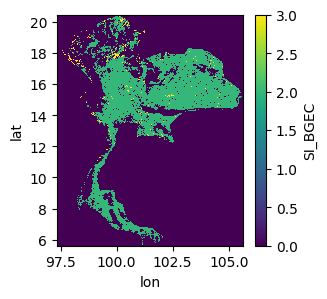

In [9]:
fig, ax = plt.subplots(figsize=(3,3))
xr_landuse_suitability_index['SI_BGEC'].plot(ax = ax,zorder = 0)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Index(['index', 'lat', 'lon', 'lccs_class', 'SI_BGEC', 'SI_Biomass',
       'SI_Solar', 'SI_Wind', 'SI_BGWW', 'SI_MSW', 'SI_IEW', 'aux', 'geometry',
       'index_right', 'FNODE_', 'TNODE_', 'LPOLY_', 'RPOLY_', 'LENGTH',
       'TRANS_', 'TRANS_ID', 'TR_TYPE', 'distance'],
      dtype='object')


C:\Users\EGAT\AppData\Local\Temp\ipykernel_23732\1557492836.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_landuse_suitability_index['aux'].loc[df_landuse_suitability_index['distance'] <= (lccs_resolution*2)] = 0


<xarray.Dataset>
Dimensions:     (lat: 5346, lon: 2985)
Coordinates:
  * lat         (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon         (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    lccs_class  (lat, lon) uint8 210 210 210 210 210 210 ... 40 30 40 50 50 50
    SI_BGEC     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Biomass  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Solar    (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Wind     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_BGWW     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_MSW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_IEW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    aux         (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1


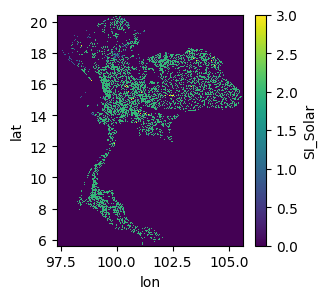

In [10]:
## Next, lets deal with a transportation network ##
trans = gpd.read_file('Data\\trans\\Trans.shp')
trans.crs = {'init': 'epsg:4326'}
trans = trans.to_crs({'init': 'epsg:3857'})

df_landuse_suitability_index = xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))
df_landuse_suitability_index.crs = {'init': 'epsg:4326'}
df_landuse_suitability_index = df_landuse_suitability_index.to_crs({'init': 'epsg:3857'})

df_landuse_suitability_index_trans = gpd.sjoin_nearest(df_landuse_suitability_index,trans,distance_col="distance",how='left')
df_landuse_suitability_index_trans.reset_index(inplace=True)

print(df_landuse_suitability_index_trans.columns)
for i in df_landuse_suitability_index_trans.columns:
    if i not in (['lon','lat','distance']):
        df_landuse_suitability_index_trans = df_landuse_suitability_index_trans.drop(columns=i)

df_landuse_suitability_index_trans = df_landuse_suitability_index_trans.groupby(['lat', 'lon']).agg('mean')
df_landuse_suitability_index_trans.reset_index(inplace=True)

df_landuse_suitability_index['distance'] = df_landuse_suitability_index_trans['distance']
df_landuse_suitability_index['aux'].loc[df_landuse_suitability_index['distance'] <= (lccs_resolution*2)] = 0

df_landuse_suitability_index['SI_BGEC'] = df_landuse_suitability_index['SI_BGEC'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Biomass'] = df_landuse_suitability_index['SI_Biomass'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Solar'] = df_landuse_suitability_index['SI_Solar'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Wind'] = df_landuse_suitability_index['SI_Wind'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_BGWW'] = df_landuse_suitability_index['SI_BGWW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_MSW'] = df_landuse_suitability_index['SI_MSW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_IEW'] = df_landuse_suitability_index['SI_IEW'] * df_landuse_suitability_index['aux']

df_landuse_suitability_index = df_landuse_suitability_index.drop(columns=['geometry','distance'])
df_landuse_suitability_index = df_landuse_suitability_index.set_index(['lat', 'lon'])
xr_landuse_suitability_index = xr.Dataset.from_dataframe(df_landuse_suitability_index)

print(xr_landuse_suitability_index)
fig, ax = plt.subplots(figsize=(3,3))
xr_landuse_suitability_index['SI_Solar'].plot(ax = ax,zorder = 0)


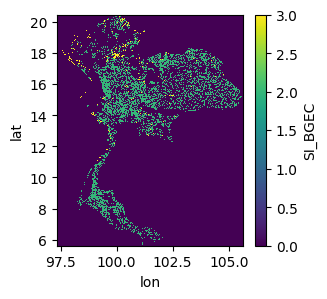

In [11]:
fig, ax = plt.subplots(figsize=(3,3))
xr_landuse_suitability_index['SI_BGEC'].plot(ax = ax,zorder = 0)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_23732\237938565.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  apa['apa'] = apa['geometry'].buffer(0.05)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyp

<xarray.Dataset>
Dimensions:     (lat: 5346, lon: 2985)
Coordinates:
  * lat         (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon         (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    lccs_class  (lat, lon) uint8 210 210 210 210 210 210 ... 40 30 40 50 50 50
    SI_BGEC     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Biomass  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Solar    (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Wind     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_BGWW     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_MSW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_IEW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    aux         (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1


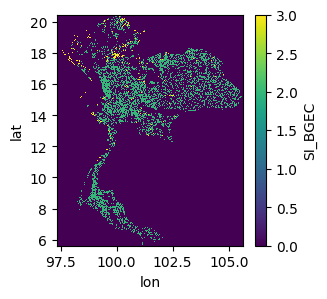

In [12]:
## Next, I assign area in airports as 0 suitability index ##
apa = gpd.read_file('Data\\thaairport2015\\THA_airport2015.shp')
apa.crs = {'init': 'epsg:4326'}
apa['apa'] = apa['geometry'].buffer(0.05)

df_landuse_suitability_index = xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))
df_landuse_suitability_index.crs = {'init': 'epsg:4326'}

for i in range(len(apa['apa'])) :
    df_landuse_suitability_index['aux'].loc[(df_landuse_suitability_index['aux'] == 1) & (df_landuse_suitability_index.within(apa['apa'][i]))] = 0

df_landuse_suitability_index['SI_BGEC'] = df_landuse_suitability_index['SI_BGEC'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Biomass'] = df_landuse_suitability_index['SI_Biomass'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Solar'] = df_landuse_suitability_index['SI_Solar'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Wind'] = df_landuse_suitability_index['SI_Wind'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_BGWW'] = df_landuse_suitability_index['SI_BGWW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_MSW'] = df_landuse_suitability_index['SI_MSW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_IEW'] = df_landuse_suitability_index['SI_IEW'] * df_landuse_suitability_index['aux']

## Next, I assign area in transmission right as 0 suitability index ##
transline = gpd.read_file('Data\\transmission_lines\\Transmission_linesLine.shp')
transline.crs = {'init': 'epsg:3857'}
transline = transline.to_crs({'init': 'epsg:4326'})
transline['buffer'] = transline['geometry'].buffer(0.01)

for i in range(len(transline['buffer'])) :
    df_landuse_suitability_index['aux'].loc[(df_landuse_suitability_index['aux'] == 1) & (df_landuse_suitability_index.within(transline['buffer'][i]))] = 0

df_landuse_suitability_index['SI_BGEC'] = df_landuse_suitability_index['SI_BGEC'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Biomass'] = df_landuse_suitability_index['SI_Biomass'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Solar'] = df_landuse_suitability_index['SI_Solar'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Wind'] = df_landuse_suitability_index['SI_Wind'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_BGWW'] = df_landuse_suitability_index['SI_BGWW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_MSW'] = df_landuse_suitability_index['SI_MSW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_IEW'] = df_landuse_suitability_index['SI_IEW'] * df_landuse_suitability_index['aux']

df_landuse_suitability_index = df_landuse_suitability_index.drop(columns='geometry')
df_landuse_suitability_index = df_landuse_suitability_index.set_index(['lat', 'lon'])
xr_landuse_suitability_index = xr.Dataset.from_dataframe(df_landuse_suitability_index)

print(xr_landuse_suitability_index)
fig, ax = plt.subplots(figsize=(3,3))
xr_landuse_suitability_index['SI_BGEC'].plot(ax = ax,zorder = 0)

In [13]:
### Next, I exclude existing plant and RE Biglot #### 
existingplants = pd.read_csv("Data\\ExistingPlants_wPosition.csv")
existingplants = gpd.GeoDataFrame(existingplants, geometry =gpd.points_from_xy(existingplants['longitude'],existingplants['latitude']))
existingplants.crs = {'init': 'epsg:4326'}
# existingplants = existingplants.loc[existingplants['EXP_MW'] >= 1]
existingplants.reset_index(inplace=True,drop=True)
        
for i in existingplants.columns:
    if i not in ['Sale_MW','FuelTypeName','latitude','longitude','geometry']:
        existingplants = existingplants.drop(columns=i)

existingplants['area'] = existingplants['geometry'].buffer(0.026)

REbiglot = pd.read_excel('Data\\NewVRE.xlsx',sheet_name='สรุปผู้ที่ได้รับการคัดเลือก')
REbiglot = gpd.GeoDataFrame(REbiglot, geometry =gpd.points_from_xy(REbiglot['lon'],REbiglot['lat']))
REbiglot.crs = {'init': 'epsg:4326'}
REbiglot.reset_index(inplace=True,drop=True)

REbiglot['area'] = REbiglot['geometry'].buffer(0.026)

df_landuse_suitability_index = xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))
df_landuse_suitability_index.crs = {'init': 'epsg:4326'}
df_landuse_suitability_index['aux'] = 1

for i in range(len(existingplants)) :
    df_landuse_suitability_index['aux'].loc[(df_landuse_suitability_index['aux'] == 1) & (df_landuse_suitability_index.within(existingplants['area'][i]))] = 0

for i in range(len(REbiglot)) :
    df_landuse_suitability_index['aux'].loc[(df_landuse_suitability_index['aux'] == 1) & (df_landuse_suitability_index.within(REbiglot['area'][i]))] = 0

df_landuse_suitability_index['SI_BGEC'] = df_landuse_suitability_index['SI_BGEC'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Biomass'] = df_landuse_suitability_index['SI_Biomass'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Solar'] = df_landuse_suitability_index['SI_Solar'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Wind'] = df_landuse_suitability_index['SI_Wind'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_BGWW'] = df_landuse_suitability_index['SI_BGWW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_MSW'] = df_landuse_suitability_index['SI_MSW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_IEW'] = df_landuse_suitability_index['SI_IEW'] * df_landuse_suitability_index['aux']

df_landuse_suitability_index = df_landuse_suitability_index.drop(columns=['aux','geometry'])
df_landuse_suitability_index = df_landuse_suitability_index.set_index(['lat', 'lon'])
xr_landuse_suitability_index = xr.Dataset.from_dataframe(df_landuse_suitability_index)


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_23732\2260903420.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  existingplants['area'] = existingplants['geometry'].buffer(0.026)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis 

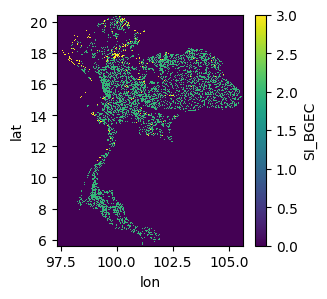

In [14]:
fig, ax = plt.subplots(figsize=(3,3))
xr_landuse_suitability_index['SI_BGEC'].plot(ax = ax,zorder = 0)

In [15]:
xr_landuse_suitability_index.to_netcdf(path='Output\\xr_SI_Landcover_beforefeedstock.nc')

In [16]:
print(xr_landuse_suitability_index)

<xarray.Dataset>
Dimensions:     (lat: 5346, lon: 2985)
Coordinates:
  * lat         (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon         (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    lccs_class  (lat, lon) uint8 210 210 210 210 210 210 ... 40 30 40 50 50 50
    SI_BGEC     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Biomass  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Solar    (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Wind     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_BGWW     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_MSW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_IEW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0


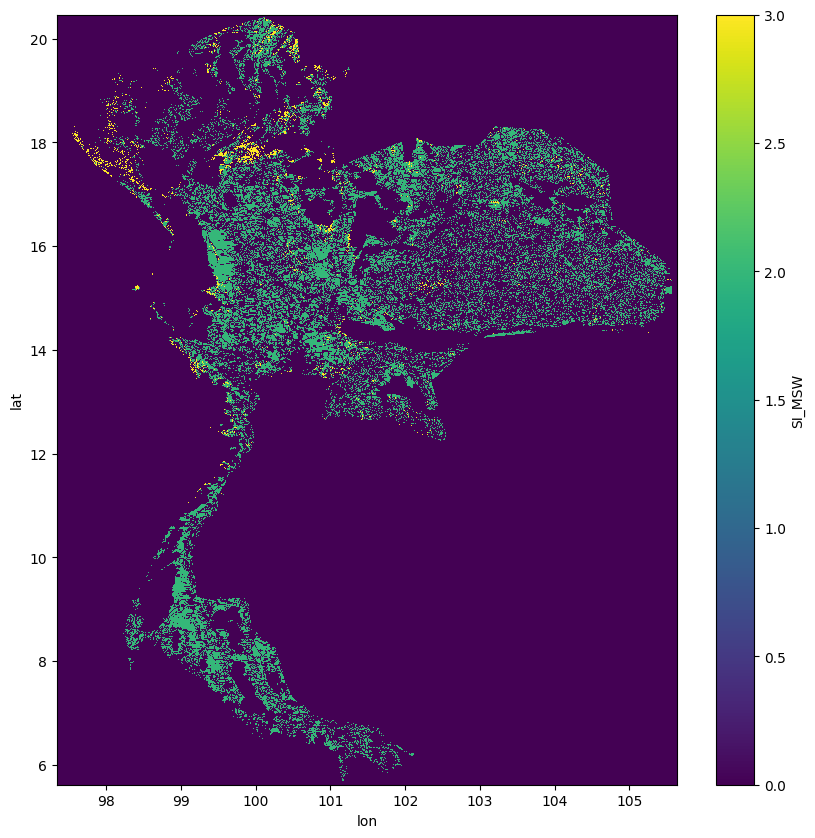

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
xr_landuse_suitability_index['SI_MSW'].plot(ax = ax,zorder = 0)